# Imports

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio
import librosa
import glob

import IPython.display as ipd
from IPython.display import Audio
import librosa.display as lid

import seaborn as sns
import matplotlib.pyplot as plt

# Load Data

In [3]:
BASE_PATH = '/kaggle/input/birdclef-2023'

device = "GPU"

if device=="TPU":
    from kaggle_datasets import KaggleDatasets
    GCS_PATH = KaggleDatasets().get_gcs_path(BASE_PATH.split('/')[-1])
else:
    GCS_PATH = BASE_PATH# Load Data

In [4]:
df_metadata = pd.read_csv(f'{BASE_PATH}/train_metadata.csv')

class_names = sorted(os.listdir('/kaggle/input/birdclef-2023/train_audio/'))
num_classes = len(class_names)
class_labels = list(range(num_classes))
label_dict = dict(zip(class_names, class_labels))

df_metadata['filepath'] = GCS_PATH + '/train_audio/' + df_metadata.filename
df_metadata['target'] = df_metadata.primary_label.map(label_dict)
df_metadata.head()

primary_label secondary_labels              type  latitude  longitude  \
0       abethr1               []          ['song']    4.3906    38.2788   
1       abethr1               []          ['call']   -2.9524    38.2921   
2       abethr1               []          ['song']   -2.9524    38.2921   
3       abethr1               []          ['song']   -2.9524    38.2921   
4       abethr1               []  ['call', 'song']   -2.9524    38.2921   

      scientific_name               common_name         author  \
0  Turdus tephronotus  African Bare-eyed Thrush  Rolf A. de By   
1  Turdus tephronotus  African Bare-eyed Thrush  James Bradley   
2  Turdus tephronotus  African Bare-eyed Thrush  James Bradley   
3  Turdus tephronotus  African Bare-eyed Thrush  James Bradley   
4  Turdus tephronotus  African Bare-eyed Thrush  James Bradley   

                                             license  rating  \
0  Creative Commons Attribution-NonCommercial-Sha...     4.0   
1  Creative Commons Attribution-NonCommercial-Sha...     3.5   
2  Creative Commons Attribution-NonCommercial-Sha...     3.5   
3  Creative Commons Attribution-NonCommercial-Sha...     5.0   
4  Creative Commons Attribution-NonCommercial-Sha...     4.5   

                                 url              filename  \
0  https://www.xeno-canto.org/128013  abethr1/XC128013.ogg   
1  https://www.xeno-canto.org/363501  abethr1/XC363501.ogg   
2  https://www.xeno-canto.org/363502  abethr1/XC363502.ogg   
3  https://www.xeno-canto.org/363503  abethr1/XC363503.ogg   
4  https://www.xeno-canto.org/363504  abethr1/XC363504.ogg   

                                            filepath  target  
0  /kaggle/input/birdclef-2023/train_audio/abethr...       0  
1  /kaggle/input/birdclef-2023/train_audio/abethr...       0  
2  /kaggle/input/birdclef-2023/train_audio/abethr...       0  
3  /kaggle/input/birdclef-2023/train_audio/abethr...       0  
4  /kaggle/input/birdclef-2023/train_audio/abethr...       0

In [5]:
# from sklearn.preprocessing import LabelEncoder

# encoder = LabelEncoder()
# all_labels = sorted(df_metadata['primary_label'].values)
# encoder.fit(all_labels)

# df_metadata['primary_label'] = encoder.transform(df_metadata['primary_label'])

In [6]:
tf.io.gfile.exists(df_metadata.filepath.iloc[0])

True

In [7]:
label_value_count = df_metadata.primary_label.value_counts()
label_value_count

barswa     500
wlwwar     500
thrnig1    500
eaywag1    500
comsan     500
          ... 
lotcor1      1
whctur2      1
whhsaw1      1
afpkin1      1
crefra2      1
Name: primary_label, Length: 264, dtype: int64

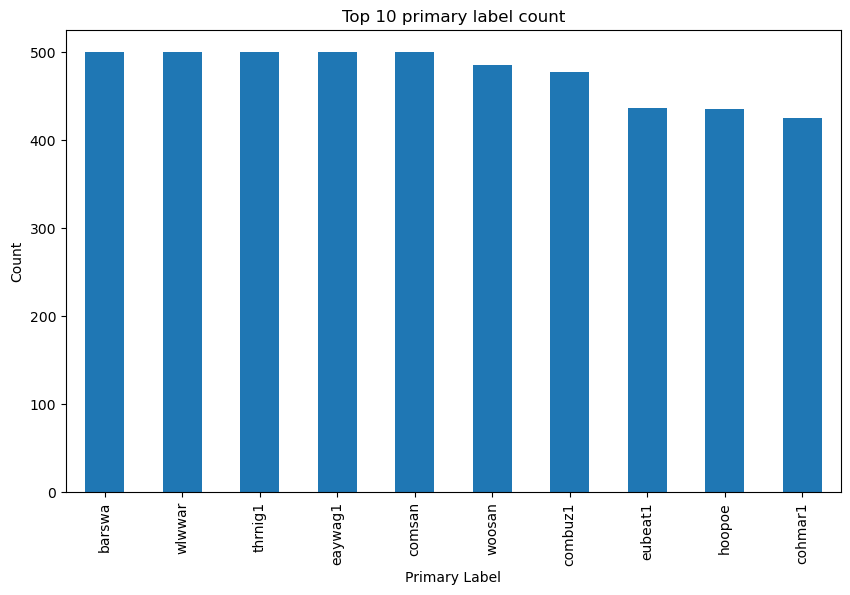

In [8]:
# create bar plot
plt.figure(figsize=(10, 6))
label_value_count[:10].plot(kind='bar')
plt.title('Top 10 primary label count')
plt.xlabel('Primary Label')
plt.ylabel('Count')
plt.show()

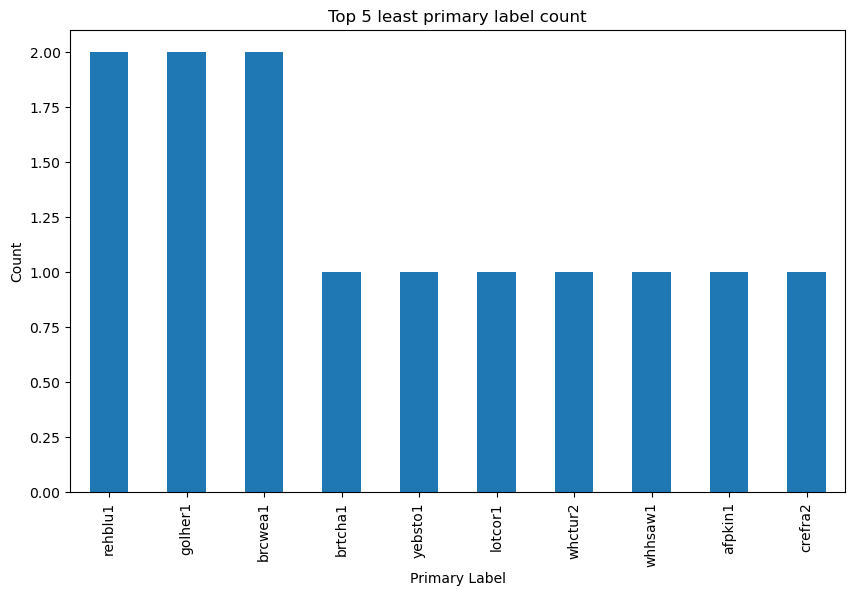

In [9]:
plt.figure(figsize=(10, 6))
label_value_count[-10:].plot(kind='bar')
plt.title('Top 5 least primary label count')
plt.xlabel('Primary Label')
plt.ylabel('Count')
plt.show()

# EDA

In [10]:
duration = 5 # second
sample_rate = 32000
audio_len = duration*sample_rate

In [11]:
# Input image size and batch size
img_size = [224, 448]

'''
Load audio and sample_rate from filepath
'''
def load_audio(filepath):
    print(filepath)
    audio, sample_rate = librosa.load(filepath)
    return audio, sample_rate

'''
Create spectogram from audio and sample_rate
'''
def create_spectogram(audio, sample_rate):
    spec = librosa.feature.melspectrogram(y = audio, sr=sample_rate)
    
    spec = librosa.power_to_db(spec, ref=np.max)
    return spec

'''
Displays audio with row information
'''
def display_row_info(row, crop=True):
    caption = f'Common Name: {row.common_name} \n Scientific Name: {row.scientific_name} \n Rating: {row.rating} \n Filename: {row.filename}'

    # read audio from filepath
    print(row.filepath)
    audio, sample_rate = load_audio(row.filepath)
    
    duration = 5 # second
    sample_rate = 32000
    if(crop):
        audio_len = duration*sample_rate

        audio = audio[:audio_len]
    # create spectogram from audio
    spectogram = create_spectogram(audio, sample_rate)
    
    print('=' * 10, " Audio ", '=' * 10)
    display(Audio(audio, rate=sample_rate))
    
    print('=' * 10, ' Visualization ', '=' * 10)
    fig, ax = plt.subplots(2, 1, figsize=(12, 2*3), sharex=True, tight_layout=True)
    fig.suptitle(caption)
    
    # Waveplot
    lid.waveshow(audio,
                 sr=sample_rate,
                 ax=ax[0])
    
    lid.specshow(spectogram, sr = sample_rate,
                 x_axis = 'time', 
                 y_axis = 'mel',
                 cmap = 'coolwarm',
                 ax=ax[1])
    ax[0].set_xlabel('');
    fig.show()
    plt.show()

lotcor1      1
whctur2      1
whhsaw1      1
afpkin1      1
crefra2      1

/kaggle/input/birdclef-2023/train_audio/crefra2/XC667443.ogg
/kaggle/input/birdclef-2023/train_audio/crefra2/XC667443.ogg
==========  Audio  ==========


==========  Visualization  ==========


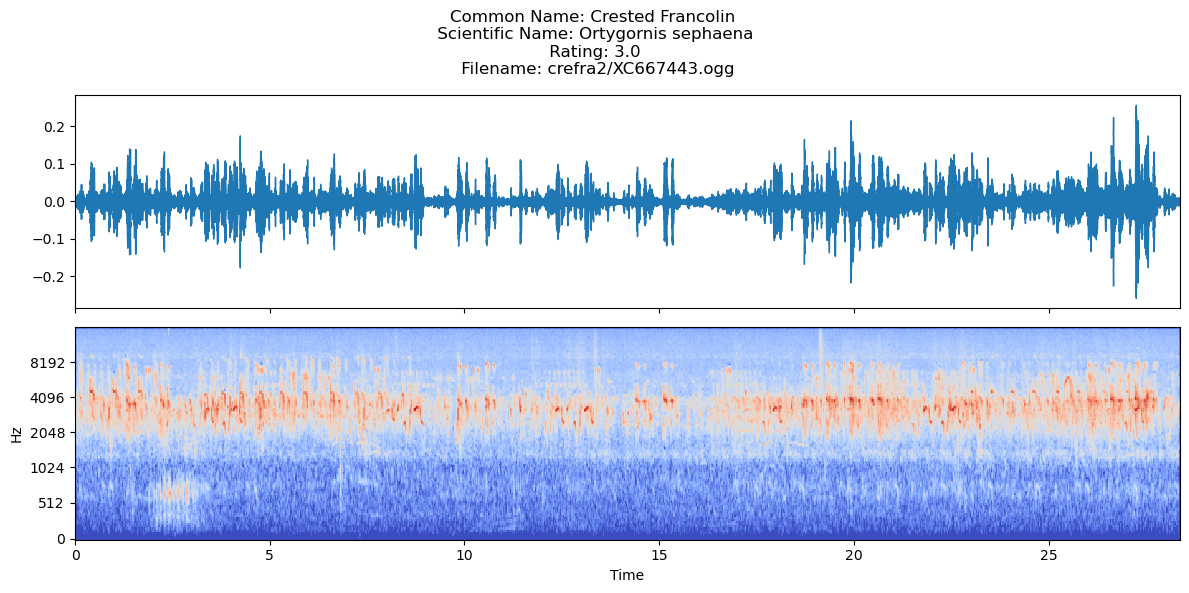

In [12]:
gg = df_metadata[df_metadata['primary_label'] == 'crefra2']
for i, sample in gg.iterrows():
    display_row_info(sample, crop=False)

primary_label                                                 rbsrob1
secondary_labels                                                   []
type                                                             ['']
latitude                                                     -26.7739
longitude                                                     26.6944
scientific_name                               Cercotrichas leucophrys
common_name                                    Red-backed Scrub-Robin
author                                                    Tony Archer
license             Creative Commons Attribution-NonCommercial-Sha...
rating                                                            4.5
url                                     https://xeno-canto.org/704627
filename                                         rbsrob1/XC704627.ogg
filepath            /kaggle/input/birdclef-2023/train_audio/rbsrob...
target                                                            169
Name: 11342, dtype: 

==========  Visualization  ==========


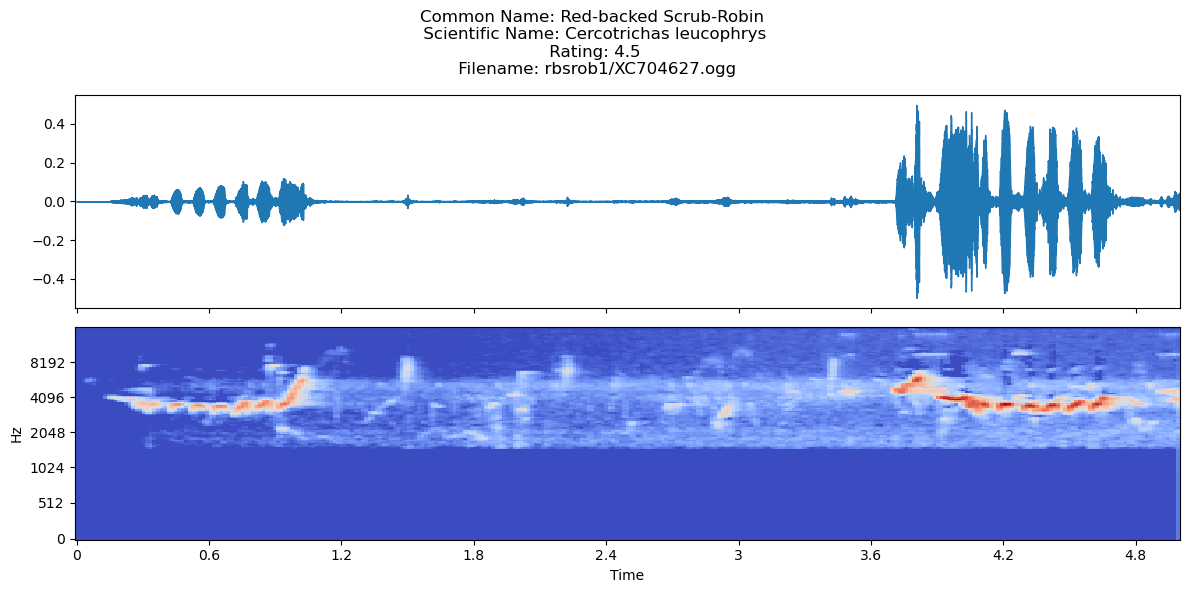

primary_label                                                  litegr
secondary_labels                                                   []
type                ['adult', 'alarm call', 'flight call', 'sex un...
latitude                                                      51.2277
longitude                                                     -2.9996
scientific_name                                      Egretta garzetta
common_name                                              Little Egret
author                                                      Paul Bate
license             Creative Commons Attribution-NonCommercial-Sha...
rating                                                            2.5
url                                      http://xeno-canto.org/672786
filename                                          litegr/XC672786.ogg
filepath            /kaggle/input/birdclef-2023/train_audio/litegr...
target                                                            135
Name: 9984, dtype: o

==========  Visualization  ==========


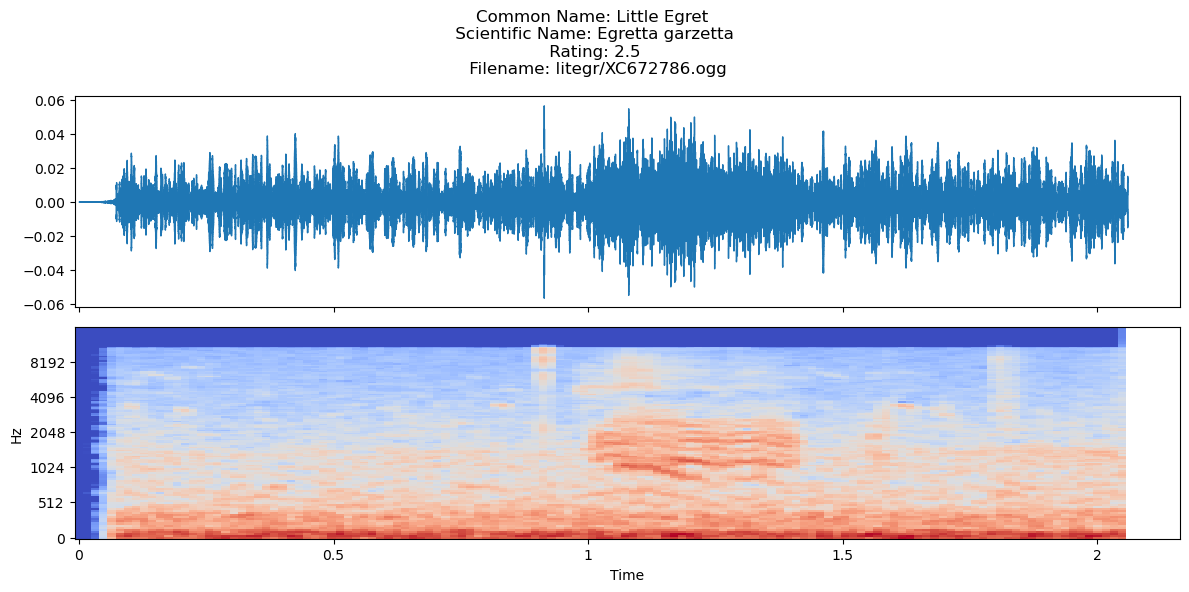

primary_label                                                  comsan
secondary_labels                                                   []
type                                        ['nocturnal flight call']
latitude                                                      42.5042
longitude                                                      2.0681
scientific_name                                    Actitis hypoleucos
common_name                                          Common Sandpiper
author                                                   Emmanuel Roy
license             Creative Commons Attribution-NonCommercial-Sha...
rating                                                            4.0
url                                      http://xeno-canto.org/681863
filename                                          comsan/XC681863.ogg
filepath            /kaggle/input/birdclef-2023/train_audio/comsan...
target                                                             74
Name: 5450, dtype: o

==========  Visualization  ==========


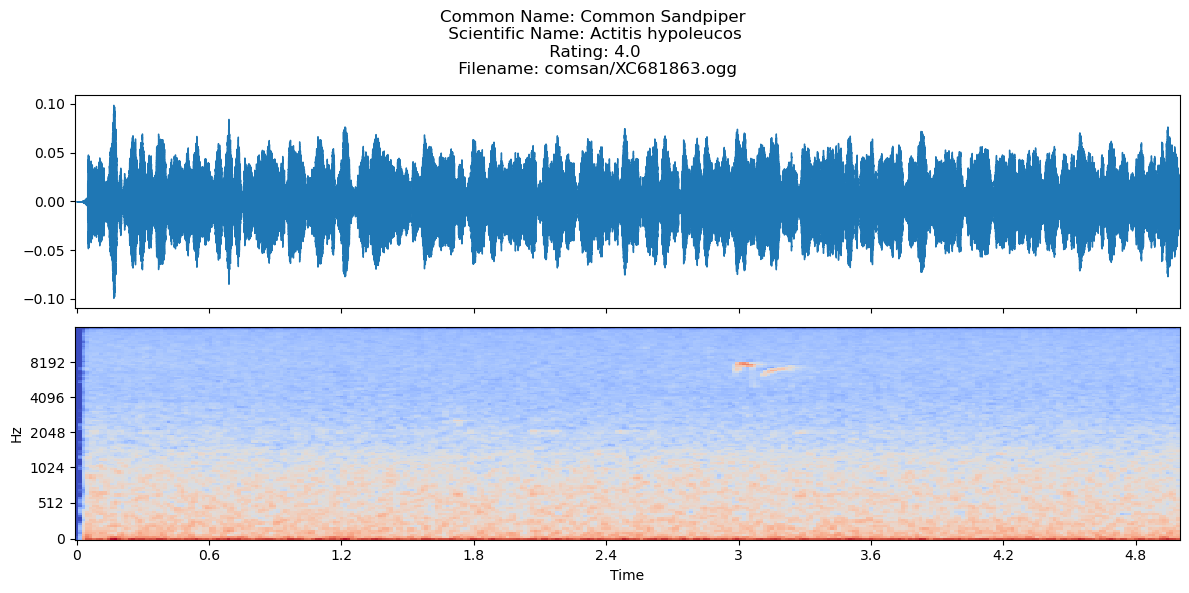

In [13]:
sample_rows = df_metadata.sample(n=3)

for i, sample in sample_rows.iterrows():
    print(sample)
    display_row_info(sample)

# Split Data

In [14]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

df_metadata["fold"] = -1

# Iterate over the folds and assign the corresponding fold number to each row in the dataframe
for fold, (train_idx, val_idx) in enumerate(skf.split(df_metadata, df_metadata['primary_label'])):
    df_metadata.loc[val_idx, 'fold'] = fold

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


In [15]:
df_metadata[df_metadata['fold'] == 1].groupby(['primary_label']).count()

secondary_labels  type  latitude  longitude  scientific_name  \
primary_label                                                                 
abethr1                       3     3         3          3                3   
abhori1                      25    25        25         25               25   
abythr1                       6     6         6          6                6   
afbfly1                       4     4         4          4                4   
afdfly1                       6     6         6          6                6   
...                         ...   ...       ...        ...              ...   
yertin1                      27    27        27         27               27   
yesbar1                       5     5         5          5                5   
yespet1                       3     3         3          3                3   
yetgre1                       6     6         6          6                6   
yewgre1                      21    21        21         21               21   

               common_name  author  license  rating  url  filename  filepath  \
primary_label                                                                  
abethr1                  3       3        3       3    3         3         3   
abhori1                 25      25       25      25   25        25        25   
abythr1                  6       6        6       6    6         6         6   
afbfly1                  4       4        4       4    4         4         4   
afdfly1                  6       6        6       6    6         6         6   
...                    ...     ...      ...     ...  ...       ...       ...   
yertin1                 27      27       27      27   27        27        27   
yesbar1                  5       5        5       5    5         5         5   
yespet1                  3       3        3       3    3         3         3   
yetgre1                  6       6        6       6    6         6         6   
yewgre1                 21      21       21      21   21        21        21   

               target  fold  
primary_label                
abethr1             3     3  
abhori1            25    25  
abythr1             6     6  
afbfly1             4     4  
afdfly1             6     6  
...               ...   ...  
yertin1            27    27  
yesbar1             5     5  
yespet1             3     3  
yetgre1             6     6  
yewgre1            21    21  

[253 rows x 14 columns]

In [16]:
len(df_metadata['primary_label'].unique())

264

In [17]:
label_counts = df_metadata['primary_label'].value_counts()

# Filter the results to only include labels with a count less than 10
rare_labels = label_counts[label_counts <= 5].index.tolist()

# Print the rare labels
print(rare_labels)
print(len(rare_labels))

['gobwea1', 'rehwea1', 'hunsun2', 'fatwid1', 'witswa1', 'stusta1', 'palpri1', 'lotlap1', 'gobsta5', 'dotbar1', 'brcsta1', 'shesta1', 'rehblu1', 'golher1', 'brcwea1', 'brtcha1', 'yebsto1', 'lotcor1', 'whctur2', 'whhsaw1', 'afpkin1', 'crefra2']
22


# PYTORCH IMPLEMENTATION

In [18]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn.functional as F
import torchaudio
from torchaudio import transforms
from IPython.display import Audio
import torchvision
import random

In [19]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed = 42
seed_everything(seed)

In [20]:
class Config:
    isOneHot = False
    sample_rate = 32000
    num_classes = 264

In [21]:
# Load Audio
audio, sample_rate = torchaudio.load('/kaggle/input/birdclef-2023/train_audio/abethr1/XC128013.ogg')
print('shape:',audio.shape)
print('rate:', sample_rate)

shape: torch.Size([1, 1459513])
rate: 32000


In [22]:
class AudioUtil():
    @staticmethod
    def load_audio(filepath):
#         audio, sample_rate = torchaudio.load(filepath)
        audio, sample_rate = torchaudio.load(filepath)
        return audio, sample_rate
    
    @staticmethod
    def mono_to_stereo(audio):
        sterio_audio = torch.cat((audio, audio), dim=0)
        
#         print(sterio_audio.shape)
        return sterio_audio
    
    @staticmethod
    def resample(audio, new_sample_rate = 32000):
        audio, sr = audio
        transform = torchaudio.transforms.Resample(sr, new_sample_rate)
        resampled_audio = transform(audio)
        return resampled_audio, new_sample_rate
    
    @staticmethod
    def crop_or_pad(audio, max_ms):
        audio, sr = audio
        num_rows, sig_len = audio.shape
        max_len = sr//1000 * max_ms

        if (sig_len > max_len):
          # Truncate the signal to the given length
          audio = audio[:,:max_len]

        elif (sig_len < max_len):
            # Length of padding to add at the beginning and end of the signal
            pad_begin_len = random.randint(0, max_len - sig_len)
            pad_end_len = max_len - sig_len - pad_begin_len
            
            # Pad with 0s
            pad_begin = torch.zeros((num_rows, pad_begin_len))
            pad_end = torch.zeros((num_rows, pad_end_len))
            
            audio = torch.cat((pad_begin, audio, pad_end), 1)

        return audio
    
    @staticmethod
    def shift(audio, shift_range = 0.04):
        audio, sample_rate = audio
        
        # calculate pitch shift factor
        pitch_shift_factor = 2 ** (shift_range / 12)
        
        # convert to numpy to use on librosa
#         print(audio)
        audio = audio.numpy()
        
        pitch_shifted_audio = librosa.effects.pitch_shift(
            audio, 
            sr=sample_rate,
            n_steps=pitch_shift_factor, 
            bins_per_octave=12
        )
        
        return torch.from_numpy(pitch_shifted_audio), sample_rate
    
    @staticmethod
    def time_warp(audio, time_warp_factor = 0.8):
        audio, sr = audio
        
        # Compute the time warp center and radius
        center = np.random.uniform(low=time_warp_factor, high=sr - time_warp_factor)
        radius = time_warp_factor
        
        # Generate the warped time axis
        time_warp = np.arange(n_steps)
        time_warp = center + radius * (time_warp - center) / np.abs(time_warp - center)
        
        # Apply the time warp to the audio signal
        audio = librosa.effects.time_warp(audio, time_warp)
        
        audio = torch.from_numpy(audio)
        return (audio_stretch, sr)
    
    @staticmethod
    def convert_to_melspectrogram(aud, n_mels=64, n_fft=1024, hop_len=None):
        audio, sample_rate = aud
        top_db = 80
        
        # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
        spec = torchaudio.transforms.MelSpectrogram(sample_rate, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(audio)
        
        # Convert to decibels
        spec = torchaudio.transforms.AmplitudeToDB(top_db=top_db)(spec)
        
        # Convert to 3 channels
#         spec = spec.repeat(2, 1, 1)
        return spec

#         spec = spec_3d.mean(dim=0, keepdim=True)
#         spec_gray = spec.expand(3, -1, -1)

#         return spec_gray
#         return spec
    @staticmethod
    def mixup(audio, audio2, alpha=1.0):
        lam = np.random.beta(alpha, alpha)
        index = torch.randperm(audio.size()[1])
        mixed_audio = lam * audio + (1 - lam) * audio2
#         target_a, target_b = target, target[index]
        return mixed_audio
    
    @staticmethod
    def cutup(audio, target, alpha=2):
        lam = np.random.beta(alpha, alpha)
        rand_index = torch.randperm(audio.size()[1])
        rand_index[0] = 0
        target_a = audio[:, :rand_index[0]]
        target_b = audio[:, rand_index[0]:]
        bbx1, bby1, bbx2, bby2 = AudioUtil.rand_bbox(audio.size(), lam)
        audio[:, bbx1:bbx2] = audio[:, bbx1:bbx2] * lam + target_b[:, bbx1:bbx2] * (1. - lam)
        return audio
    
    @staticmethod
    def rand_bbox(size, lam):
        W = size[-1]
        H = size[-2]
        cut_rat = np.sqrt(1. - lam)
        cut_w = np.int64(W * cut_rat)
        cut_h = np.int64(H * cut_rat)

        # uniform
        cx = np.random.randint(W)
        cy = np.random.randint(H)

        bbx1 = np.clip(cx - cut_w // 2, 0, W)
        bby1 = np.clip(cy - cut_h // 2, 0, H)
        bbx2 = np.clip(cx + cut_w // 2, 0, W)
        bby2 = np.clip(cy + cut_h // 2, 0, H)

        return bbx1, bby1, bbx2, bby2

    @staticmethod
    def white_noise(audio, snr=10):
        noise = torch.randn_like(audio)
    
        # Calculate signal power
        power = torch.mean(audio ** 2)

        # Calculate noise power
        noise_power = power / (10 ** (snr / 10))

        # Scale noise to appropriate power
        scaled_noise = noise * torch.sqrt(noise_power)

        # Add noise to audio
        noisy_audio = audio + scaled_noise

        # Clip values to range [-1, 1]
        return torch.clamp(noisy_audio, -1, 1)

    @staticmethod
    def melspec_gaussian_noise(spec, mean=0.0, std=0):
        # Generate Gaussian noise with the same shape as the input spectrogram
        noise = torch.randn_like(spec) * std + mean

        # Add the noise to the input spectrogram
        spec_noisy = spec + noise
    
        # Clip the values to make sure they are within the valid range of the spectrogram
        spec_noisy = torch.clamp(spec_noisy, min=0.0, max=1.0)
        
#         print("NOISE")
#         print(spec_noisy.shape)
        return spec_noisy

# DATASET

In [31]:
class AudioDS(Dataset):
    def __init__(self, df, is_train = True, file_path = '/kaggle/input/birdclef-2023/train_audio/'):
        self.df = df
        self.data_path = str(file_path)
        self.duration = 5000
        self.sample_rate = Config.sample_rate
        self.channel = 2
        self.shift_pct = 0.4
        self.labels = df['target']
        self.is_train = is_train
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        audio_path = self.df.loc[index, 'filepath']
        
        class_id  = self.df.loc[index, 'target']
        rating = self.df.loc[index, 'rating']
        label = self.df.loc[index, 'primary_label'] 
        
        audio, sr = AudioUtil.load_audio(audio_path)
        audio, sr = AudioUtil.resample((audio, sr), self.sample_rate)
        audio = AudioUtil.mono_to_stereo(audio)
#         if(label in rare_labels and self.is_train):
        audio = AudioUtil.crop_or_pad((audio, sr), self.duration)
        # Augment
        
#         if(self.is_train and torch.rand(1) >= 0.5):
#             other_index = np.random.choice([i for i in range(len(self.df)) if i != index])
#             other_audio_path = self.df.loc[other_index, 'filepath']
#             other_audio, other_audio_sr = AudioUtil.load_audio(other_audio_path)
#             other_audio, other_audio_sr = AudioUtil.resample((other_audio, other_audio_sr), self.sample_rate)
#             other_audio = AudioUtil.mono_to_stereo(other_audio)
#     #         if(label in rare_labels and self.is_train):
#             other_audio = AudioUtil.crop_or_pad((other_audio, other_audio_sr), self.duration)
            
#             audio = AudioUtil.mixup(audio, other_audio)  
            
        if(self.is_train and torch.rand(1) >= 0.5):
            audio = AudioUtil.cutup(audio, label)
            
        
        if(self.is_train and torch.rand(1) >= 0.5):
            audio = AudioUtil.white_noise(audio)
        
        if(self.is_train and torch.rand(1) >= 0.5):
            audio, sr = AudioUtil.shift((audio, sr), self.shift_pct)
        
        
        spectogram = AudioUtil.convert_to_melspectrogram((audio, sr))
#         spectogram = spectogram.mean(dim=0, keepdim=True)

        #add noise if rating is > 3.5
#         if(self.is_train and rating >= 3.5 and torch.rand(1) > 0):
#             spectogram = AudioUtil.melspec_gaussian_noise(spectogram)
            
        mel_spec_rgb = spectogram.repeat(3, 1, 1)
        mel_spec_3ch = torch.zeros((3, spectogram.shape[1], spectogram.shape[2]))
        mel_spec_3ch[:2, :, :] = spectogram
        
        image = mel_spec_3ch 
        label_onehot = torch.zeros([Config.num_classes])
        label_onehot[self.labels[index]] = 1
        label = torch.tensor(self.labels[index])
        
        # normalize
        inputs_m, inputs_s = image.mean(), image.std()
        image = (image - inputs_m) / inputs_s
        return {
            "image": image, 
            "label": label,
            "label_onehot": label_onehot
        }
#         return spectogram, class_id.item()

In [32]:
train_ds = AudioDS(df_metadata[df_metadata['fold'] != 0].reset_index())
val_ds = AudioDS(df_metadata[df_metadata['fold'] == 0].reset_index(), is_train = False)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=64, shuffle=True)

In [33]:
def show_batch_stereo(img_ds, num_items, num_rows, num_cols, predict_arr=None):
    fig = plt.figure(figsize=(15, 10))
    index = 0
    for i in range(num_rows):
        for j in range(num_cols):
            if index == num_items:
                break
            item = img_ds[index]
            melspec = item['image'].numpy()
            melspec = melspec.transpose(1, 2, 0)
#             print(i, "GG")
#             print(melspec.shape)
            ax = fig.add_subplot(num_rows, num_cols, index + 1, xticks=[], yticks=[])
            ax.imshow(melspec[:, :, i])
            title = f"Mel spectrogram {index + 1}"
            ax.set_title(title)
            index += 1
        if index == num_items:
            break

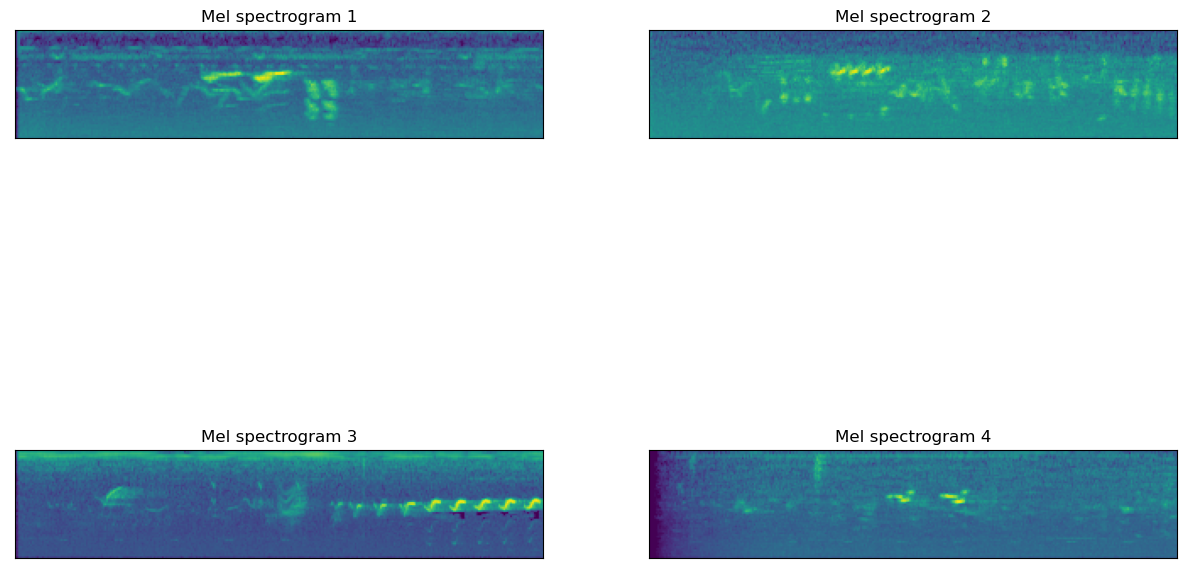

In [37]:
show_batch_stereo(train_ds, 4, 2, 2)

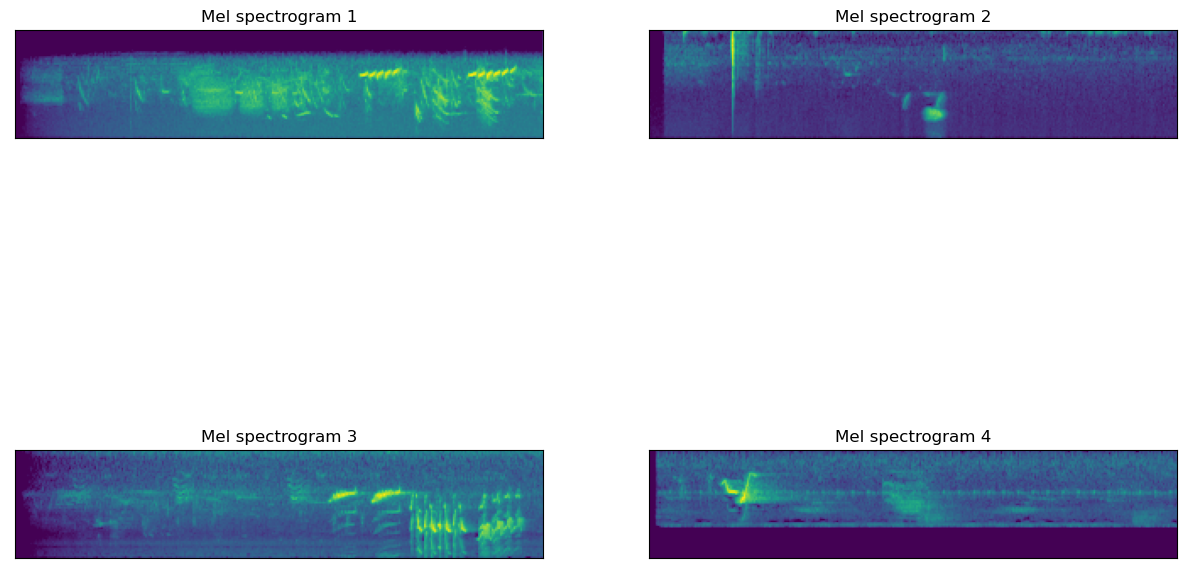

In [27]:
show_batch_stereo(val_ds, 4, 2, 2)

# Model

In [38]:
import pandas as pd
import sklearn.metrics

def padded_cmap(solution, submission, padding_factor=5):
    solution = solution
    submission = submission
    
    new_rows = []
    for i in range(padding_factor):
        new_rows.append([1 for i in range(len(solution.columns))])
    new_rows = pd.DataFrame(new_rows)
    new_rows.columns = solution.columns
    padded_solution = pd.concat([solution, new_rows]).reset_index(drop=True).copy()
    padded_submission = pd.concat([submission, new_rows]).reset_index(drop=True).copy()
    
    score = sklearn.metrics.average_precision_score(
        padded_solution.values,
        padded_submission.values,
        average='macro',
    )
    return score

def padded_cmap2(y_true, y_pred, padding_factor=5):
    num_classes = y_true.shape[1]
    pad_rows = np.array([[1]*num_classes]*padding_factor)
    y_true = np.concatenate([y_true, pad_rows])
    y_pred = np.concatenate([y_pred, pad_rows])
    score = sklearn.metrics.average_precision_score(y_true, y_pred, average='macro',)
    return score

In [39]:
import timm

# Load the EfficientNet model
model = timm.create_model('tf_efficientnet_b0_ns', pretrained=True)

# Replace the last linear layer with a new one that has the correct number of output classes
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, Config.num_classes)

# Set the requires_grad attribute of all parameters to False except for the newly added layer
for name, param in model.named_parameters():
    if "classifier" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Move the model to the device (GPU if available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model.load_state_dict(torch.load('/kaggle/working/Cmap BirdSound_Effnet_fold0_epoch.pth'))
model = model.to(device)

# Training

In [ ]:
def training(model, train_dl, val_dl, num_epochs):
    # Loss, Optimizer, Scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-4,
                                                   steps_per_epoch=int(len(train_dl)),
                                                    epochs=num_epochs)
    
    best_acc = -1
    best_cmap = -1
    for epoch in range(num_epochs):
        running_loss = 0
        correct_predict = 0
        total_predict = 0
        for i, data in enumerate(train_dl):
            data, label, label_orig = data['image'].to(device), data['label_onehot'].to(device), data['label'].to(device)
#             data, label = data.to(device), label.to(device)
            
#             inputs_m, inputs_s = data.mean(), data.std()
#             data = (data - inputs_m) / inputs_s
        
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
#             print(data.shape)
            output = model(data)
            
            # Calculate loss
            loss = criterion(output, label)
            
            # Backward pass
            loss.backward()
            
            # Update parameters
            optimizer.step()
            scheduler.step()
            
            # Keep stats for Loss and Accuracy
            running_loss += loss.item()
            predicted = torch.argmax(output, 1)
            correct_predict += (predicted == label_orig).sum()
            total_predict += label_orig.size(0)
            
            if (i + 1) % 1 == 0:    # print every 10 mini-batches
                print('Epoch [{}/{}], Step [{}/{}], Loss : {:.4f}, Train Acc : {:.4f}'
                .format(epoch + 1, num_epochs, i + 1, len(train_dl), running_loss/(i + 1), correct_predict / total_predict))
            
            if i % 10 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, i * len(data), len(train_dl.dataset),
                    100. * i / len(train_dl), loss.item()))
                
#         print(f"Train Acc at epoch # {epoch}: {correct_predict / total_predict}")
        model.eval()
        predictions = []
        true_labels = []
        
        PREDS = []
        LABELS = []
        with torch.no_grad():
            val_correct_predict = 0
            val_total_predict = 0
            val_loss = 0
            
            predictions = []
            true_labels = []
            for idx, (data) in enumerate(val_dl):
                data, label, label_orig = data['image'].to(device), data['label_onehot'].to(device), data['label'].to(device)
                
#                 inputs_m, inputs_s = data.mean(), data.std()
#                 data = (data - inputs_m) / inputs_s
                
                # Forward pass
                output = model(data)
                
                # Calculate loss
                loss = criterion(output, label)
                
                val_loss += loss.item()
                
                predicted = torch.argmax(output, 1)
                correct_predict += (predicted == label_orig).sum().item()
                total_predict += label_orig.size(0)
                
                pred_labels = output.argmax(dim=1)
#                 predictions.extend(pred_labels.cpu())
#                 true_labels.extend(label.cpu())
                
                predictions.append(F.softmax(output, dim=1).cpu().detach().numpy())
                true_labels.append(label.cpu().detach().numpy())
                
            # Compute metrics on validation set
            val_acc = correct_predict / total_predict
            val_loss /= len(val_dl)
            print('Epoch [{}/{}], Val Loss: {:.4f}, Val Acc: {:.4f}'.format(epoch + 1, num_epochs, val_loss, val_acc))
            
            LABELS = np.vstack(true_labels)
            PREDS = np.vstack(predictions)
            score = padded_cmap(pd.DataFrame(LABELS), pd.DataFrame(PREDS))
            
            print(f'Padded cmap score: {score:.4f}')
            
#             if (best_acc < val_acc):
#                 best_acc = val_acc
#                 print("Saving best model...")
#                 torch.save(model.state_dict(), f'BirdSound_Effnet_fold0_epoch{epoch}.pth')
                
            if (score >= best_cmap):
                best_cmap = score
                print("Best CMAP: ", score)
                torch.save(model.state_dict(), f'Cmap BirdSound_Effnet_fold{0}_epoch.pth')
                
    print('Finished Training')
    
num_epochs = 32
training(model, train_dl, val_dl, num_epochs)

Epoch [1/32], Step [1/212], Loss : 5.6280, Train Acc : 0.0000
Train Epoch: 0 [0/13552 (0%)]	Loss: 5.628048
Epoch [1/32], Step [2/212], Loss : 5.6090, Train Acc : 0.0000
Epoch [1/32], Step [3/212], Loss : 5.6088, Train Acc : 0.0000
Epoch [1/32], Step [4/212], Loss : 5.6023, Train Acc : 0.0000
Epoch [1/32], Step [5/212], Loss : 5.5983, Train Acc : 0.0000
Epoch [1/32], Step [6/212], Loss : 5.5933, Train Acc : 0.0000
Epoch [1/32], Step [7/212], Loss : 5.5903, Train Acc : 0.0022
Epoch [1/32], Step [8/212], Loss : 5.5889, Train Acc : 0.0020
Epoch [1/32], Step [9/212], Loss : 5.5890, Train Acc : 0.0035
Epoch [1/32], Step [10/212], Loss : 5.5856, Train Acc : 0.0031
Epoch [1/32], Step [11/212], Loss : 5.5853, Train Acc : 0.0028
Train Epoch: 0 [640/13552 (5%)]	Loss: 5.582515
Epoch [1/32], Step [12/212], Loss : 5.5814, Train Acc : 0.0039
Epoch [1/32], Step [13/212], Loss : 5.5811, Train Acc : 0.0048
Epoch [1/32], Step [14/212], Loss : 5.5789, Train Acc : 0.0045
Epoch [1/32], Step [15/212], Loss :

In [ ]:
class Audio():
    @staticmethod
    def open(filepath):
        audio, sample_rate = torchaudio.load(filepath)
        return audio, sample_rate
    
    @staticmethod
    def rechannel(audio, new_channel):
        audio, sr = audio
        
        if (audio.shape[0] == new_channel):
          # Nothing to do
          return 
        
#         if (new_channel == 1):
          # Convert from stereo to mono by selecting only the first channel
#           new_audio = audio[:1, :]
#         else:
          # Convert from mono to stereo by duplicating the first channel
        new_audio = torch.cat([audio, audio, audio])

        return ((new_audio, sr))
    
    @staticmethod
    def resample(aud, new_sample_rate):
        audio, sr = aud

        if (sr == new_sample_rate):
          # Nothing to do
          return aud

        num_channels = audio.shape[0]
        # Resample first channel
        new_audio = torchaudio.transforms.Resample(sr, new_sample_rate)(audio[:1,:])
        if (num_channels > 1):
            # Resample the second channel and merge both channels
            retwo = torchaudio.transforms.Resample(sr, new_sample_rate)(audio[1:,:])
            resig = torch.cat([new_audio, retwo])

        return ((resig, newsr))
    
    @staticmethod
    def add_noise(audio, noise_factor=0.05):
        audio, sample_rate = audio
        noise = torch.randn_like(audio)
        augmented_audio = audio + noise_factor * noise
        return (augmented_audio, sample_rate)
    
    @staticmethod
    def crop_or_pad(audio, max_ms):
        audio, sr = audio
        num_rows, sig_len = audio.shape
        max_len = sr//1000 * max_ms

        if (sig_len > max_len):
          # Truncate the signal to the given length
          audio = audio[:,:max_len]

        elif (sig_len < max_len):
            # Length of padding to add at the beginning and end of the signal
            pad_begin_len = random.randint(0, max_len - sig_len)
            pad_end_len = max_len - sig_len - pad_begin_len
            
            # Pad with 0s
            pad_begin = torch.zeros((num_rows, pad_begin_len))
            pad_end = torch.zeros((num_rows, pad_end_len))
            
            audio = torch.cat((pad_begin, audio, pad_end), 1)

        return (audio, sr)
    
    @staticmethod
    def time_shift(audio, shift_limit):
        audio, sample_rate = audio
        _, sig_len = audio.shape
        shift_amt = int(random.random() * shift_limit * sig_len)
        return (audio.roll(shift_amt), sample_rate)
    
    @staticmethod
    def convert_to_melspectrogram(aud, n_mels=64, n_fft=1024, hop_len=None):
        audio, sample_rate = aud
        top_db = 80

        # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
        spec = torchaudio.transforms.MelSpectrogram(sample_rate, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(audio)

        # Convert to decibels
        spec = torchaudio.transforms.AmplitudeToDB(top_db=top_db)(spec)
        return (spec)


# Dataloader

In [ ]:
df_metadata.head()

In [ ]:
class AudioDS(Dataset):
    def __init__(self, df, file_path = '/kaggle/input/birdclef-2023/train_audio/'):
        self.df = df
        self.data_path = str(file_path)
        self.duration = 5000
        self.sample_rate = Config.sample_rate
        self.channel = 3
        self.shift_pct = 0.4
        self.labels = df['target']
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        audio_path = self.df.loc[index, 'filepath']
        
        class_id  = self.df.loc[index, 'target']
        rating = self.df.loc[index, 'rating']
        
        audio = Audio.open(audio_path)
        audio = Audio.resample(audio, self.sample_rate)
        #add noise if rating is > 3.5
#         if(rating >= 3.5 and random.random() > 0.0):
#             audio = Audio.add_noise(audio)
        audio = Audio.rechannel(audio, self.channel)
        
        # augment
        if(random.random() > 0.0):
            audio = Audio.crop_or_pad(audio, self.duration)
        if(random.random() > 0.0):
            audio = Audio.time_shift(audio, self.shift_pct)
        
#         if(random.random() > 0.5):
#             audio = Audio.change_speed_and_pitch(audio)
            
        spectogram = Audio.convert_to_melspectrogram(audio)
        
        label_onehot = torch.zeros([Config.num_classes])
        label_onehot[self.labels[index]] = 1
        label = torch.tensor(self.labels[index])
        
        return {
            "image": spectogram, 
            "label": label,
            "label_onehot": label_onehot
        }
#         return spectogram, class_id.item()

In [ ]:
train_ds = AudioDS(df_metadata[df_metadata['fold'] != 0].reset_index())
val_ds = AudioDS(df_metadata[df_metadata['fold'] == 0].reset_index())

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=64, shuffle=True)

In [ ]:
def show_batch(img_ds, num_items, num_rows, num_cols, predict_arr=None):
    fig = plt.figure(figsize=(12, 6))    
    img_index = np.random.randint(0, len(img_ds), num_items)
    for index, img_index in enumerate(img_index):  # list first 9 images\
        img = img_ds[img_index]['image']   
        
        ax = fig.add_subplot(num_rows, num_cols, index + 1, xticks=[], yticks=[])
        if isinstance(img, torch.Tensor):
            img = img.detach().numpy()
        if isinstance(img, np.ndarray):
            print(img.shape)
            img = img.transpose(1, 2, 0)
            ax.imshow(img)        
            
        title = f"Spec"
        ax.set_title(title)  

In [ ]:
show_batch(val_ds, 2, 2, 1)

In [ ]:
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + \
                '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + \
                ', ' + 'eps=' + str(self.eps) + ')'

In [ ]:
import timm
# tf_efficientnet_b0_ns
model = timm.create_model('tf_efficientnet_b0_ns', pretrained=True)

num_features = model.classifier.in_features
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
next(model.parameters()).device

num_ftrs = model.classifier.in_features
# model.embedding = nn.Linear(num_ftrs, 768)
model.classifier = nn.Linear(num_ftrs, Config.num_classes)

for param in model.parameters():
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True

model = model.to(device)

class BirdCLEFModel(nn.Module):
    def __init__(self, model_name, embedding_size = 768, pretrained=True):
        super(BirdCLEFModel, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Identity()
        self.model.global_pool = nn.Identity()
        self.pooling = GeM()
        self.embedding = nn.Linear(in_features, embedding_size)
        self.fc = nn.Linear(embedding_size, Config.num_classes)

    def forward(self, images):
        features = self.model(images)
        pooled_features = self.pooling(features).flatten(1)
        embedding = self.embedding(pooled_features)
        output = self.fc(embedding)
        return output

# model = BirdCLEFModel('tf_efficientnet_b0_ns')
# model = model.to(device)

# Training

In [ ]:
import pandas as pd
import sklearn.metrics

def padded_cmap(solution, submission, padding_factor=5):
    solution = solution
    submission = submission
    
    new_rows = []
    for i in range(padding_factor):
        new_rows.append([1 for i in range(len(solution.columns))])
    new_rows = pd.DataFrame(new_rows)
    new_rows.columns = solution.columns
    padded_solution = pd.concat([solution, new_rows]).reset_index(drop=True).copy()
    padded_submission = pd.concat([submission, new_rows]).reset_index(drop=True).copy()
    
    score = sklearn.metrics.average_precision_score(
        padded_solution.values,
        padded_submission.values,
        average='macro',
    )
    return score

def padded_cmap2(y_true, y_pred, padding_factor=5):
    num_classes = y_true.shape[1]
    pad_rows = np.array([[1]*num_classes]*padding_factor)
    y_true = np.concatenate([y_true, pad_rows])
    y_pred = np.concatenate([y_pred, pad_rows])
    score = sklearn.metrics.average_precision_score(y_true, y_pred, average='macro',)
    return score

In [ ]:
def training(model, train_dl, val_dl, num_epochs):
    # Loss, Optimizer, Scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3,
                                                   steps_per_epoch=int(len(train_dl)),
                                                    epochs=num_epochs)
    
    best_acc = -1
    best_cmap = -1
    for epoch in range(num_epochs):
        running_loss = 0
        correct_predict = 0
        total_predict = 0
        for i, data in enumerate(train_dl):
            data, label, label_orig = data['image'].to(device), data['label_onehot'].to(device), data['label'].to(device)
#             data, label = data.to(device), label.to(device)
            
            inputs_m, inputs_s = data.mean(), data.std()
            data = (data - inputs_m) / inputs_s
        
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            output = model(data)
            
            # Calculate loss
            loss = criterion(output, label)
            
            # Backward pass
            loss.backward()
            
            # Update parameters
            optimizer.step()
            scheduler.step()
            
            # Keep stats for Loss and Accuracy
            running_loss += loss.item()
            predicted = torch.argmax(output, 1)
            correct_predict += (predicted == label_orig).sum().item()
            total_predict += label_orig.size(0)
            
            if (i + 1) % 1 == 0:    # print every 10 mini-batches
                print('Epoch [{}/{}], Step [{}/{}], Loss : {:.4f}, Train Acc : {:.4f}'
                .format(epoch + 1, num_epochs, i + 1, len(train_dl), running_loss/(i + 1), correct_predict / total_predict))
            
            if i % 10 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, i * len(data), len(train_dl.dataset),
                    100. * i / len(train_dl), loss.item()))
                
#         print(f"Train Acc at epoch # {epoch}: {correct_predict / total_predict}")
        model.eval()
        predictions = []
        true_labels = []
        
        PREDS = []
        LABELS = []
        with torch.no_grad():
            val_correct_predict = 0
            val_total_predict = 0
            val_loss = 0
            
            predictions = []
            true_labels = []
            for idx, (data) in enumerate(val_dl):
                data, label, label_orig = data['image'].to(device), data['label_onehot'].to(device), data['label'].to(device)
                
                inputs_m, inputs_s = data.mean(), data.std()
                data = (data - inputs_m) / inputs_s
                
                # Forward pass
                output = model(data)
                
                # Calculate loss
                loss = criterion(output, label)
                
                val_loss += loss.item()
                
                predicted = torch.argmax(output, 1)
                correct_predict += (predicted == label_orig).sum().item()
                total_predict += label_orig.size(0)
                
                pred_labels = output.argmax(dim=1)
#                 predictions.extend(pred_labels.cpu())
#                 true_labels.extend(label.cpu())
                
                predictions.append(F.softmax(output, dim=1).cpu().detach().numpy())
                true_labels.append(label.cpu().detach().numpy())
                
            # Compute metrics on validation set
            val_acc = correct_predict / total_predict
            val_loss /= len(val_dl)
            print('Epoch [{}/{}], Val Loss: {:.4f}, Val Acc: {:.4f}'.format(epoch + 1, num_epochs, val_loss, val_acc))
            
            LABELS = np.vstack(true_labels)
            PREDS = np.vstack(predictions)
            score = padded_cmap(pd.DataFrame(LABELS), pd.DataFrame(PREDS))
            
            print(f'Padded cmap score: {score:.4f}')
            
#             if (best_acc < val_acc):
#                 best_acc = val_acc
#                 print("Saving best model...")
#                 torch.save(model.state_dict(), f'BirdSound_Effnet_fold0_epoch{epoch}.pth')
                
            if (score >= best_cmap):
                best_cmap = score
                print("Best CMAP: ", score)
                torch.save(model.state_dict(), f'Cmap BirdSound_Effnet_fold{0}_epoch.pth')
                
    print('Finished Training')
    
num_epochs = 32
training(model, train_dl, val_dl, num_epochs)

In [ ]:
birds = list(df_metadata.primary_label.unique()) 

In [ ]:
num_epochs = 32
training(model, train_dl, val_dl, num_epochs)

# TENSORFLOW

# Data Augmentation

In [ ]:
import tensorflow as tf

@tf.function
def timeshift(audio, sr=32000, prob=0.5):
    shift = tf.random.uniform(shape=[], minval=0, maxval=tf.shape(audio)[0], dtype=tf.int32)
    
    shifted_audio = tf.roll(audio, int(shift * sr), axis=0)
    
    if len(shifted_audio) < len(audio):
        pad_len = len(audio) - len(shifted_audio)
        shifted_audio = tf.pad(shifted_audio, [(0, pad_len), (0, 0)], 'CONSTANT')
    else:
        shifted_audio = shifted_audio[:len(audio)]
        
    return shifted_audio

@tf.function
def add_noise(audio, snr_db=15):
    rnd = tf.random.uniform(shape=[], minval=0.0025, maxval=0.025, dtype=tf.float32)
    GN = tf.keras.layers.GaussianNoise(stddev=rnd)
    audio = GN(audio, training=True)
    
    return audio

@tf.function
def CropOrPad(audio, target_len, pad_mode='constant'):
    # Get the length of the input audio
    local_audio_len = tf.shape(audio)[0]
    # If the length of the input audio is smaller than the target length, randomly pad the audio
    if local_audio_len < target_len:
        # Calculate the offset between the input audio and the target length
        diff_len = (target_len - local_audio_len)
        # Select a random location for padding
        pad1 = tf.random.uniform(shape=[], minval=0, maxval=diff_len, dtype=tf.int32)
        # Calculate the second padding value
        pad2 = diff_len - pad1
        pad_len = [pad1, pad2]
        # Apply padding to the audio data
        audio = tf.pad(audio, paddings=[pad_len], mode=pad_mode)
    # If the length of the input audio is larger than the target length, crop the audio
    elif local_audio_len > target_len:
        # Calculate the difference in length between the input audio and the target length
        diff_len = (local_audio_len - target_len)
        # Select a random location for cropping
        idx = tf.random.uniform([], 0, diff_len, dtype=tf.int32)
        # Crop the audio data
        audio = audio[idx: (idx + target_len)]
    # Reshape the audio data to the target length
    audio = tf.reshape(audio, [target_len])
    # Return the cropped or padded audio data
    return audio

In [ ]:
def show_original_augmented(row):
    caption = f'Common Name: {row.common_name} \n Scientific Name: {row.scientific_name} \n Rating: {row.rating} \n Filename: {row.filename}'
    
    audio, sample_rate = load_audio(row.filepath)
    fig, ax = plt.subplots(4, 1, figsize=(15, 15), sharex=True, tight_layout=True)
    fig.suptitle(caption)
    
    ax[0].set_title("Original")
    lid.waveshow(audio,
                 sr=sample_rate,
                 ax=ax[0])
    
    ax[1].set_title("Augmented timeshift")
    augmented_timeshift = timeshift(audio, sample_rate)
    lid.waveshow(np.array(augmented_timeshift),
                 sr=sample_rate,
                 ax=ax[1])
    
    ax[2].set_title("Augmented noise")
    augmented_timestretch = add_noise(audio)
    lid.waveshow(np.array(augmented_timeshift),
                 sr=sample_rate,
                 ax=ax[2])

    duration = 5 # second
    sample_rate = 32000
    audio_len = duration*sample_rate
    
    ax[3].set_title("Augmented crop o rpad")
    augmented_cropOrPad = CropOrPad(audio, audio_len)
    lid.waveshow(np.array(augmented_cropOrPad),
                 sr=sample_rate,
                 ax=ax[3])
    
    plt.show()


In [ ]:
# read audio from filepath
for i, sample in sample_rows.iterrows():
    show_original_augmented(sample)

# Create Dataset

In [ ]:
def load_audio_tensor(filepath):
    audio_binary = tf.io.read_file(filepath)
    audio = tfio.audio.decode_vorbis(audio_binary) # decode .ogg file for .wave replace `decode_wav`

    audio = tf.cast(audio, tf.float32)
    audio = tf.squeeze(audio, axis=-1)
    sample_rate = tf.cast(32000, tf.int64)
    return audio, sample_rate

def get_target(target):          
        target = tf.reshape(target, [1])
        target = tf.cast(tf.one_hot(target, len(class_labels)), tf.float32) 
        target = tf.reshape(target, [len(class_labels)])
        return target
    
@tf.function
def create_spectogram_tensor(audio, sample_rate):
    spec = tf.numpy_function(create_spectogram, [audio, sample_rate], tf.float32)
    return spec

@tf.function
def preprocess_audio(filepath, target):
    print(filepath)

    audio, sample_rate = load_audio_tensor(filepath)
    audio = CropOrPad(audio, audio_len)

#     spectogram = create_spectogram_tensor(audio, sample_rate)
#     print(spectogram)
    spectogram = Audio2Spec(audio)
    spectogram = Spec2Img(spectogram, num_channels=3) 
    
#     spectogram = tf.reshape(spectogram, [*img_size, 3])
    return spectogram, get_target(target)

@tf.function
def Audio2Spec(audio, spec_shape=[128, 384], sr=32000, nfft=2048, window=2048, fmin=500, fmax=14000):
    """
    Computes a Mel-scaled spectrogram from audio using TensorFlow and TensorFlow-IO.
    """
    # Get the desired height and width of the spectrogram
    spec_height = spec_shape[0]
    spec_width = spec_shape[1]
    
    # Get the length of the audio and calculate the hop length for the STFT
    audio_len = tf.shape(audio)[0]
    print(audio_len)    
    print('+' * 50)
    print(audio_len // (spec_width - 1))
    hop_length = tf.cast((audio_len // (spec_width - 1)), tf.int32) # sample rate * duration / spec width - 1 == 627
    
    spec = tfio.audio.spectrogram(audio, nfft=nfft, window=window, stride=hop_length)
    mel_spec = tfio.audio.melscale(spec, rate=sr, mels=spec_height, fmin=fmin, fmax=fmax)
    db_mel_spec = tfio.audio.dbscale(mel_spec, top_db=80)
    db_mel_spec = tf.transpose(db_mel_spec, perm=[1, 0])
    
    # If the spectrogram is larger than the desired shape, crop it
    if tf.shape(db_mel_spec)[1] > spec_width:
        db_mel_spec = db_mel_spec[:, :spec_width]
    
    # Reshape the spectrogram to the desired shape and return it
    db_mel_spec = tf.reshape(db_mel_spec, spec_shape)
    return db_mel_spec

@tf.function
def Spec2Img(spec, num_channels=3):
    # If the original image has 1 channel, convert it to a 3 channel image by repeating the same image across channel axis
    if num_channels > 1:
        img = tf.tile(spec[..., tf.newaxis], [1, 1, num_channels])
    else:
        img = spec[..., tf.newaxis]
    return img

In [ ]:
@tf.function
def augment_data(spectrogram, label):
    if tf.random.uniform(()) > 0.5:
        spectrogram = add_noise(spectrogram)
    if tf.random.uniform(()) > 0.5:
        spectrogram = timeshift(spectrogram)
    return spectrogram, label

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((df_metadata['filepath'].tolist(), df_metadata['target'].tolist()))

In [ ]:
dataset.take(1)

one_element = dataset.take(1)

# Iterate over the element and print it
for element in one_element.as_numpy_iterator():
    print(element)

In [ ]:
dataset = dataset.map(preprocess_audio)

In [ ]:
dataset = dataset.map(augment_data)

In [ ]:
def get_device(device = 'GPU'):
    "Detect and intializes GPU/TPU automatically"
    # Check TPU category
    tpu = 'local' if device=='TPU-VM' else None
    try:
        # Connect to TPU
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu=tpu) 
        # Set TPU strategy
        strategy = tf.distribute.TPUStrategy(tpu)
        print(f'> Running on { device} ', tpu.master(), end=' | ')
        print('Num of TPUs: ', strategy.num_replicas_in_sync)
        device=device
    except:
        # If TPU is not available, detect GPUs
        gpus = tf.config.list_logical_devices('GPU')
        ngpu = len(gpus)
         # Check number of GPUs
        if ngpu:
            # Set GPU strategy
            strategy = tf.distribute.MirroredStrategy(gpus) # single-GPU or multi-GPU
            # Print GPU details
            print("> Running on GPU", end=' | ')
            print("Num of GPUs: ", ngpu)
            device='GPU'
        else:
            # If no GPUs are available, use CPU
            print("> Running on CPU")
            strategy = tf.distribute.get_strategy()
            device='CPU'
    return strategy, device, tpu

In [ ]:
batch_size = 32
drop_remainder = True
strategy, device, tpu = get_device()
replicas = strategy.num_replicas_in_sync

dataset1 = dataset.batch(batch_size, drop_remainder=drop_remainder)

dataset1 = dataset1.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:

def build_model(compile_model=True):
    """
    Builds and returns a model based on the specified configuration.
    """
    # Set the image input shape
    DIM = (None, None)
    # Load the specified EfficientNet model
    base = getattr(tf.keras.applications, 'EfficientNetB2')(input_shape=(*DIM, 3),
                                        include_top=False,
                                        weights='imagenet',
                                        )
    # Create an input layer for the model
    inp = tf.keras.layers.Input(shape=(*DIM, 3))
    # Pass the input through the base model
    out = base(inp)
    # Add a global average pooling layer
    out = tf.keras.layers.GlobalAveragePooling2D()(out)
    # Add a final dense layer for classification
    out = tf.keras.layers.Dense(len(class_names), activation='softmax')(out)
    # Create the TensorFlow model with the input and output layers
    model = tf.keras.Model(inputs=inp, outputs=out)
    if compile_model:
        # Set the optimizer
        opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
        # Set the loss function
        loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05) # search what label smoothing does
        # Set the evaluation metrics
        metrics = get_metrics()
        # Compile the model with the specified optimizer, loss function, and metrics
        model.compile(optimizer=opt,
                      loss=loss,
                      metrics=metrics)
    return model


In [ ]:
import sklearn.metrics

def get_metrics():
    acc = tf.keras.metrics.CategoricalAccuracy(name='acc')
    auc = tf.keras.metrics.AUC(curve='PR', name='auc') # auc on prcision-recall curve
    return [acc, auc]

def padded_cmap(y_true, y_pred, padding_factor=5):
    num_classes = y_true.shape[1]
    pad_rows = np.array([[1]*num_classes]*padding_factor)
    y_true = np.concatenate([y_true, pad_rows])
    y_pred = np.concatenate([y_pred, pad_rows])
    score = sklearn.metrics.average_precision_score(y_true, y_pred, average='macro',)
    return score

In [ ]:
model = build_model()
model.summary()

In [ ]:
ds = dataset1.take(100)
imgs, labels = next(iter(ds))

In [ ]:
out = model(imgs, training=False)
# print(out.shape)

In [ ]:
print(out.shape)

In [ ]:
out